In [1]:
%matplotlib widget

# import numpy as np
import matplotlib.pyplot as plt
# set default cmap
plt.rcParams['image.cmap'] = 'Blues'

from scipy.fft import fft
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgb, to_rgba
import matplotlib as mpl

import jax.numpy as jnp
import numpy as np
from jax import random as jrandom
import jax
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, PIDController, ControlTerm, MultiTerm, VirtualBrownianTree, Euler



import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)


In [2]:
from types import SimpleNamespace

def get_sol(f, g):
    ts = jnp.linspace(0, 100, 1000)

    t0, t1 = ts[0], ts[-1]
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jrandom.PRNGKey(0))
    # eval in interval requested

    xi = jnp.array([brownian_motion.evaluate(ts[ti], ts[ti+1]) for ti in range(len(ts)-1)])

    terms = MultiTerm(ODETerm(f), ControlTerm(g, brownian_motion))

    solver = Dopri5()
    saveat = SaveAt(ts=ts)
    y0 = jnp.array([1., 0.])

    solver = Euler()
    sol = diffeqsolve(terms, solver, t0, t1, dt0=0.05, y0=y0, saveat=saveat, max_steps=None)

    # spectrogramm
    # Parameters for STFT
    window_size = len(ts) // 10  # Size of the window
    overlap = int(window_size / 2)  # 50% overlap
    nfft = 256  # Number of FFT points

    from scipy.signal import stft


    # Compute the STFT for each 'x'
    f, t_, Zxx = stft(sol.ys[:, 0], nperseg=window_size, noverlap=overlap, nfft=nfft)
    t_stft = t_ * ts.max() / t_.max()
    Zxx = np.abs(Zxx)

    spec = SimpleNamespace(t_stft=t_stft, Zxx=Zxx, f=f)


    return sol, xi, spec

In [3]:
from pathlib import Path


def make_plot(sol, xi, spec, V, mode="add", fn=""):

    ts_sol = sol.ts
    sol = sol.ys

    x = sol[:,:1].squeeze()
    sol_v = sol[:,1:].squeeze()

    Zxx = spec.Zxx
    t_stft = spec.t_stft
    f = spec.f

    fig, axd = plt.subplot_mosaic("abc", figsize=(10, 4), width_ratios=[1, 2,2])
    ax1 = axd['a']
    ax2 = axd['b']
    ax3 = axd['c']

    axV = ax1.twinx()
    xx = np.linspace(-1, 1, 100)
    axV.plot(xx, V(xx))

    # init anim
    l1, = ax1.plot([0, x[0]], [0,0], '-')
    l1_, = ax1.plot([x[0]],[0], ls='none', marker="o")
    l_arw, = ax1.plot([0, x[0]], [0,0], '-', lw=plt.rcParams['lines.linewidth']*2, color='C1', zorder=-10)
    
    # ax1.dataLim.x0 = 0
    # ax1.dataLim.x1 = 0
    ax1.dataLim.x0 = x.min()
    ax1.dataLim.x1 = x.max()

    l2, = ax2.plot(ts_sol[:1], x[:1], '-')
    ax2.dataLim.x0 = 0
    t_max = ts_sol[(np.abs(x) > 1e-2)].max()
    print(t_max)
    ax2.dataLim.x1 = t_max
    ax2.dataLim.y0 = x.min()
    ax2.dataLim.y1 = x.max()

    # plot the spectrogram
    l3 = ax3.pcolormesh(t_stft, f, Zxx, shading='gouraud', vmin=0, vmax=Zxx.max())
    ax3.dataLim.x0 = 0
    ax3.dataLim.x1 = t_max

    # plot an animation
    def update(t):
        ti = np.argmin(np.abs(ts_sol - t))
        

        if mode == "force":
            l1.set_xdata([0, x[ti]])
            l1_.set_xdata([x[ti]])
            l_arw.set_xdata([x[ti], x[ti] + xi[ti]])
        elif mode == "add":
            l1.set_xdata([0, x[ti] + xi[ti]])
            l1_.set_xdata([x[ti] + xi[ti]])
        else:
            raise ValueError(f"Unknown mode {mode}")

        # plot the time series on ax2
        l2.set_xdata(ts_sol[:ti])
        l2.set_ydata(x[:ti])

        # plot the spectrogram
        Zxx_ = Zxx.copy()
        ti_stft = np.argmin(np.abs(t_stft - ts_sol[ti]))
        ti_stft = min(ti_stft, Zxx.shape[1])
        Zxx_[:, ti_stft:] = 0.
        l3.set_array(Zxx_.ravel())

        return l1, l2

    fps = 10
    interval = 1000/fps
    ts_draw = jnp.linspace(0, t_max, int(fps * t_max))
    ani = FuncAnimation(fig, update, frames=ts_draw, interval=interval, blit=True)
    # plt.show()

    # import os
    # from pathlib import Path
    # ani.save(Path(globals()["__vsc_ipynb_file__"]).parent / f'{fn}.gif', writer='pillow', fps=fps)

    return fig, axd, ani


In [4]:
sigma = .1

2023-10-15 10:42:57,516 Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-10-15 10:42:57,519 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-10-15 10:42:57,520 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/scripts/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


100.0


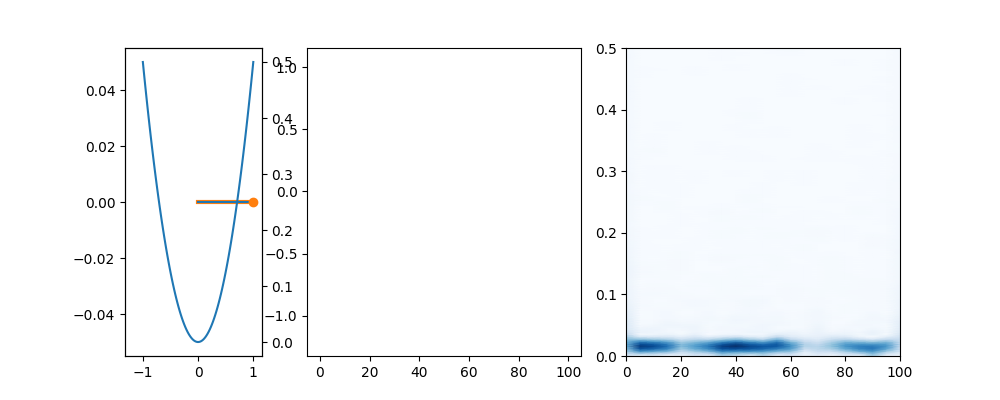

In [5]:

V2 = lambda x: x**2/2

def f(t, y, args):
    x, v = y

    dxdt = v
    gamma = 0.1
    # get grad of V with jax
    F = lambda x: -jax.grad(V2)(x)
    dvdt = F(x) - gamma*v

    return jnp.array([dxdt, dvdt])

g = lambda t, y, args: sigma

sol, xi, spec = get_sol(f, g)
fig, axd, ani = make_plot(sol, xi, spec, V2, mode="add", fn="1")

100.0


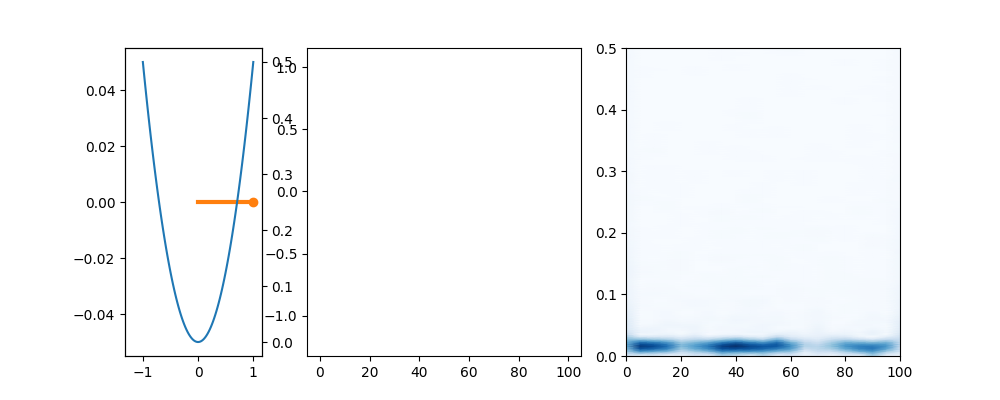

In [20]:
V2 = lambda x: x**2/2

def f(t, y, args):
    x, v = y

    dxdt = v
    gamma = 0.1
    # get grad of V with jax
    F = lambda x: -jax.grad(V2)(x)
    dvdt = F(x) - gamma*v

    return jnp.array([dxdt, dvdt])

g = lambda t, y, args: sigma

sol, xi, spec = get_sol(f, g)

fig, axd, ani = make_plot(sol, xi, spec, V2, mode="force", fn="2")

100.0


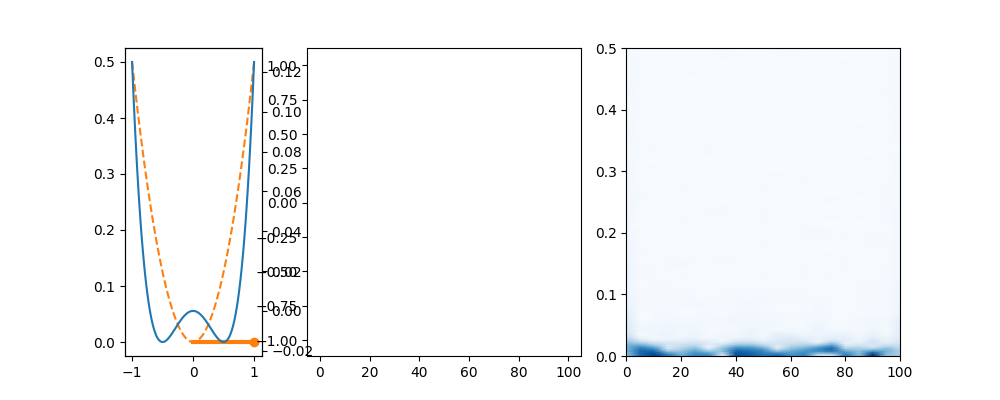

In [21]:
lmbd = .25
V4 = lambda x: -lmbd*x**2/2 + x**4/4

def f(t, y, args):
    x, v = y

    dxdt = v
    gamma = 0.1
    # get grad of V with jax
    F = lambda x: -jax.grad(V4)(x)
    dvdt = F(x) - gamma*v

    return jnp.array([dxdt, dvdt])

g = lambda t, y, args: sigma

sol, xi, spec = get_sol(f, g)

fig, axd, ani = make_plot(sol, xi, spec, V4, mode="force", fn="3")
xx = np.linspace(-1, 1, 100)
axd["a"].plot(xx, V2(xx),  ls="--", color="C1")


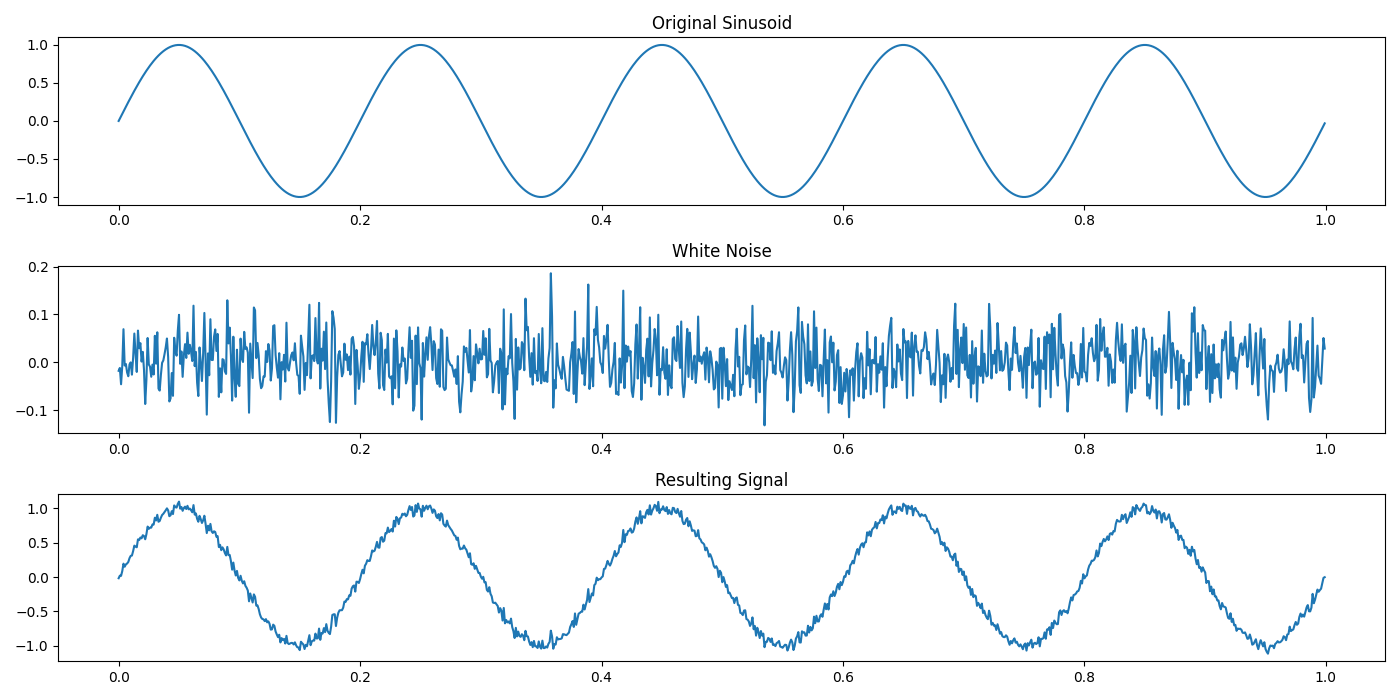

In [22]:
# Create a time vector
t = np.linspace(0, 1, 1000, False)  # 1 second

# Create a sinusoidal signal
freq = 5  # frequency of the signal
sinusoid = np.sin(2*jnp.pi*freq*t)

# Create white noise
noise = np.random.normal(0, 0.05, 1000)

# Add the sinusoid and the noise
signal = sinusoid + noise

# Plot the original sinusoid, the noise, and the resulting signal
plt.figure(figsize=(14, 7))
plt.subplot(3,1,1)
plt.plot(t, sinusoid)
plt.title('Original Sinusoid')
plt.subplot(3,1,2)
plt.plot(t, noise)
plt.title('White Noise')
plt.subplot(3,1,3)
plt.plot(t, signal)
plt.title('Resulting Signal')
plt.tight_layout()
plt.show()


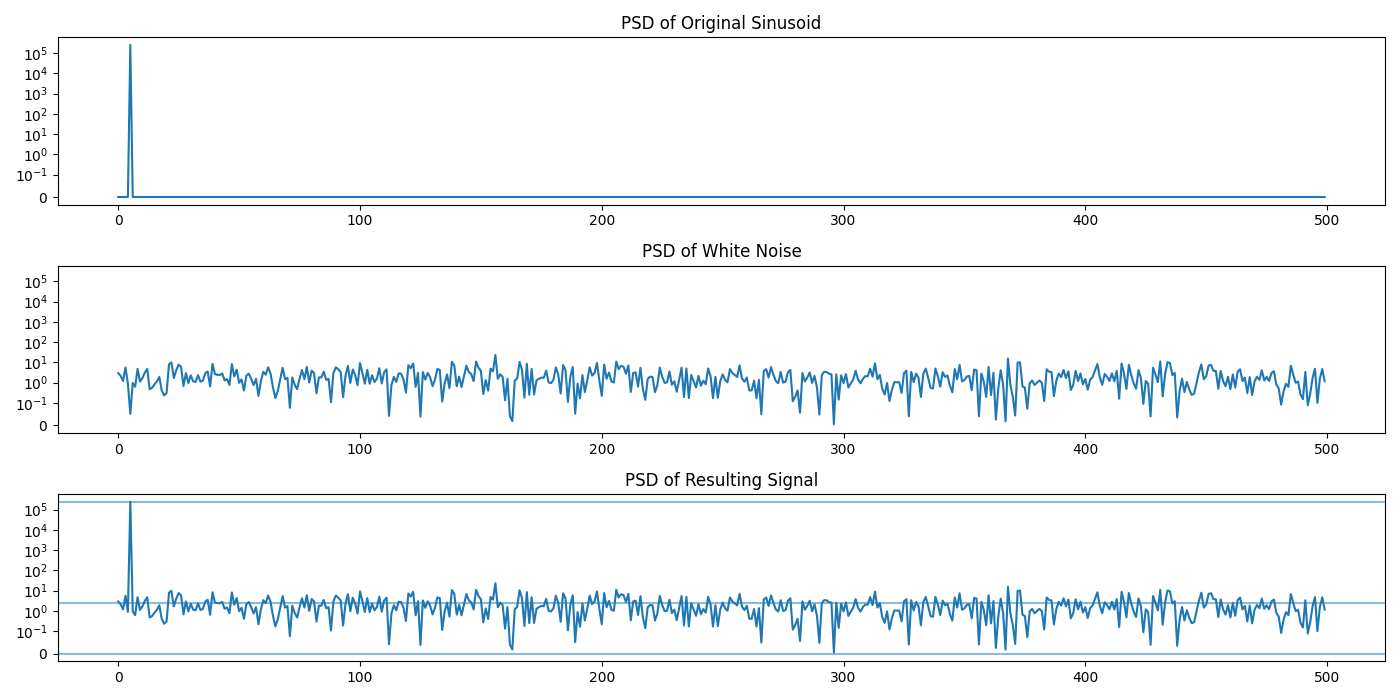

In [23]:
# Compute the FFT
fft_sinusoid = fft(sinusoid)
fft_noise = fft(noise)
fft_signal = fft(signal)

# Compute the power spectral density
psd_sinusoid = np.abs(fft_sinusoid) ** 2
psd_noise = np.abs(fft_noise) ** 2
psd_signal = np.abs(fft_signal) ** 2

# Compute the frequencies corresponding to the values of the PSD
freqs = np.fft.fftfreq(len(sinusoid), t[1]-t[0])

# Plot the power spectral density
fig, axs = plt.subplots(3, 1, figsize=(14, 7), sharey=True)
axs[0].plot(freqs[:len(freqs)//2], psd_sinusoid[:len(psd_sinusoid)//2])
axs[0].set_title('PSD of Original Sinusoid')
axs[1].plot(freqs[:len(freqs)//2], psd_noise[:len(psd_noise)//2])
axs[1].set_title('PSD of White Noise')
axs[2].plot(freqs[:len(freqs)//2], psd_signal[:len(psd_signal)//2])
axs[2].set_title('PSD of Resulting Signal')
axs[2].set_yscale("symlog", linthresh=1e-1)

axs[2].axhline(0, zorder=-1, alpha=.5)
axs[2].axhline(np.mean(psd_noise), zorder=-1, alpha=.5)
axs[2].axhline(np.max(psd_signal), zorder=-1, alpha=.5)
fig.tight_layout()
plt.show()
